**tensorflow 版本： 1.2.1**

通过本例，你可以了解到单层 LSTM 的实现，多层 LSTM 的实现。输入输出数据的格式。 RNN 的 dropout layer 的实现。

In [1]:
# -*- coding:utf-8 -*-
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data

# 设置 GPU 按需增长
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# 首先导入数据，看一下数据的形式
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print mnist.train.images.shape

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)


 ** 一、首先设置好模型用到的各个超参数 **

In [2]:
lr = 1e-3
input_size = 28      # 每个时刻的输入特征是28维的，就是每个时刻输入一行，一行有 28 个像素
timestep_size = 28   # 时序持续长度为28，即每做一次预测，需要先输入28行
hidden_size = 256    # 隐含层的数量
layer_num = 2        # LSTM layer 的层数
class_num = 10       # 最后输出分类类别数量，如果是回归预测的话应该是 1

_X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, class_num])
# 在训练和测试的时候，我们想用不同的 batch_size.所以采用占位符的方式
batch_size = tf.placeholder(tf.int32, [])  # 注意类型必须为 tf.int32, batch_size = 128
keep_prob = tf.placeholder(tf.float32, [])

 ** 二、开始搭建 LSTM 模型，其实普通 RNNs 模型也一样 **

In [3]:
# 把784个点的字符信息还原成 28 * 28 的图片
# 下面几个步骤是实现 RNN / LSTM 的关键
####################################################################
# **步骤1：RNN 的输入shape = (batch_size, timestep_size, input_size) 
X = tf.reshape(_X, [-1, 28, 28])

# # **步骤2：定义一层 LSTM_cell，只需要说明 hidden_size, 它会自动匹配输入的 X 的维度
# lstm_cell = rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=1.0, state_is_tuple=True)

# # **步骤3：添加 dropout layer, 一般只设置 output_keep_prob
# lstm_cell = rnn.DropoutWrapper(cell=lstm_cell, input_keep_prob=1.0, output_keep_prob=keep_prob)

# # **步骤4：调用 MultiRNNCell 来实现多层 LSTM
# mlstm_cell = rnn.MultiRNNCell([lstm_cell] * layer_num, state_is_tuple=True)
# mlstm_cell = rnn.MultiRNNCell([lstm_cell for _ in range(layer_num)] , state_is_tuple=True)

# 在 tf 1.0.0 版本中，可以使用上面的 三个步骤创建多层 lstm， 但是在 tf 1.2.1 版本中，可以通过下面方式来创建
def lstm_cell():
    cell = rnn.LSTMCell(hidden_size, reuse=tf.get_variable_scope().reuse)
    return rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)

mlstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(layer_num)], state_is_tuple = True)

# **步骤5：用全零来初始化state
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

# **步骤6：方法一，调用 dynamic_rnn() 来让我们构建好的网络运行起来
# ** 当 time_major==False 时， outputs.shape = [batch_size, timestep_size, hidden_size] 
# ** 所以，可以取 h_state = outputs[:, -1, :] 作为最后输出
# ** state.shape = [layer_num, 2, batch_size, hidden_size], 
# ** 或者，可以取 h_state = state[-1][1] 作为最后输出
# ** 最后输出维度是 [batch_size, hidden_size]
# outputs, state = tf.nn.dynamic_rnn(mlstm_cell, inputs=X, initial_state=init_state, time_major=False)
# h_state = state[-1][1]

# *************** 为了更好的理解 LSTM 工作原理，我们把上面 步骤6 中的函数自己来实现 ***************
# 通过查看文档你会发现， RNNCell 都提供了一个 __call__()函数，我们可以用它来展开实现LSTM按时间步迭代。
# **步骤6：方法二，按时间步展开计算
outputs = list()
state = init_state
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        if timestep > 0:
            tf.get_variable_scope().reuse_variables()
        # 这里的state保存了每一层 LSTM 的状态
        (cell_output, state) = mlstm_cell(X[:, timestep, :],state)
        outputs.append(cell_output)
h_state = outputs[-1]

 ** 三、最后设置 loss function 和 优化器，展开训练并完成测试 **

In [4]:
############################################################################
# 以下部分其实和之前写的多层 CNNs 来实现 MNIST 分类是一样的。
# 只是在测试的时候也要设置一样的 batch_size.

# 上面 LSTM 部分的输出会是一个 [hidden_size] 的tensor，我们要分类的话，还需要接一个 softmax 层
# 首先定义 softmax 的连接权重矩阵和偏置
# out_W = tf.placeholder(tf.float32, [hidden_size, class_num], name='out_Weights')
# out_bias = tf.placeholder(tf.float32, [class_num], name='out_bias')
# 开始训练和测试
W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(h_state, W) + bias)


# 损失和评估函数
cross_entropy = -tf.reduce_mean(y * tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


sess.run(tf.global_variables_initializer())
for i in range(2000):
    _batch_size = 128
    batch = mnist.train.next_batch(_batch_size)
    if (i+1)%200 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={
            _X:batch[0], y: batch[1], keep_prob: 1.0, batch_size: _batch_size})
        # 已经迭代完成的 epoch 数: mnist.train.epochs_completed
        print "Iter%d, step %d, training accuracy %g" % ( mnist.train.epochs_completed, (i+1), train_accuracy)
    sess.run(train_op, feed_dict={_X: batch[0], y: batch[1], keep_prob: 0.5, batch_size: _batch_size})

# 计算测试数据的准确率
print "test accuracy %g"% sess.run(accuracy, feed_dict={
    _X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0, batch_size:mnist.test.images.shape[0]})

Iter0, step 200, training accuracy 0.9375
Iter0, step 400, training accuracy 0.945312
Iter1, step 600, training accuracy 0.9375
Iter1, step 800, training accuracy 0.976562
Iter2, step 1000, training accuracy 0.96875
Iter2, step 1200, training accuracy 1
Iter3, step 1400, training accuracy 0.976562
Iter3, step 1600, training accuracy 0.992188
Iter4, step 1800, training accuracy 0.976562
Iter4, step 2000, training accuracy 0.984375
test accuracy 0.9839


我们一共只迭代不到5个epoch，在测试集上就已经达到了0.98的准确率，可以看出来 LSTM 在做这个字符分类的任务上还是比较有效的，而且我们最后一次性对 10000 张测试图片进行预测，才占了 725 MiB 的显存。而我们在之前的两层 CNNs 网络中，预测 10000 张图片一共用了 8721 MiB 的显存，差了整整 12 倍呀！！ 这主要是因为 RNN/LSTM 网络中，每个时间步所用的权值矩阵都是共享的，可以通过前面介绍的 LSTM 的网络结构分析一下，整个网络的参数非常少。

## 四、可视化看看 LSTM 的是怎么做分类的

毕竟 LSTM 更多的是用来做时序相关的问题，要么是文本，要么是序列预测之类的，所以很难像 CNNs 一样非常直观地看到每一层中特征的变化。在这里，我想通过可视化的方式来帮助大家理解 LSTM 是怎么样一步一步地把图片正确的给分类。

In [5]:
# 手写的结果 shape
_batch_size = 5
X_batch, y_batch = mnist.test.next_batch(_batch_size)
print X_batch.shape, y_batch.shape
_outputs, _state = np.array(sess.run([outputs, state],feed_dict={
            _X: X_batch, y: y_batch, keep_prob: 1.0, batch_size: _batch_size}))
print '_outputs.shape =', np.asarray(_outputs).shape
print 'arr_state.shape =', np.asarray(_state).shape
# 可见 outputs.shape = [ batch_size, timestep_size, hidden_size]
# state.shape = [layer_num, 2, batch_size, hidden_size]

(5, 784) (5, 10)
_outputs.shape = (28, 5, 256)
arr_state.shape = (2, 2, 5, 256)


In [6]:
_batch_size = 5
X_batch, y_batch = mnist.test.next_batch(_batch_size)
print X_batch.shape, y_batch.shape
_outputs, _state = sess.run([outputs, state],feed_dict={
            _X: X_batch, y: y_batch, keep_prob: 1.0, batch_size: _batch_size})
print '_outputs.shape =', np.asarray(_outputs).shape
print 'arr_state.shape =', np.asarray(_state).shape
# 可见 outputs.shape = [ batch_size, timestep_size, hidden_size]
# state.shape = [layer_num, 2, batch_size, hidden_size]

(5, 784) (5, 10)
_outputs.shape = (28, 5, 256)
arr_state.shape = (2, 2, 5, 256)


看下面我找了一个字符 3

In [7]:
import matplotlib.pyplot as plt

In [12]:
print mnist.train.labels[4]

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


我们先来看看这个字符样子,上半部分还挺像 2 来的

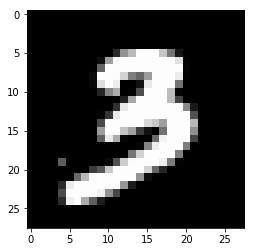

In [13]:
X3 = mnist.train.images[4]
img3 = X3.reshape([28, 28])
plt.imshow(img3, cmap='gray')
plt.show()

我们看看在分类的时候，一行一行地输入，分为各个类别的概率会是什么样子的。

In [14]:
X3.shape = [-1, 784]
y_batch = mnist.train.labels[0]
y_batch.shape = [-1, class_num]

X3_outputs = np.array(sess.run(outputs, feed_dict={
            _X: X3, y: y_batch, keep_prob: 1.0, batch_size: 1}))
print X3_outputs.shape
X3_outputs.shape = [28, hidden_size]
print X3_outputs.shape

(28, 1, 256)
(28, 256)


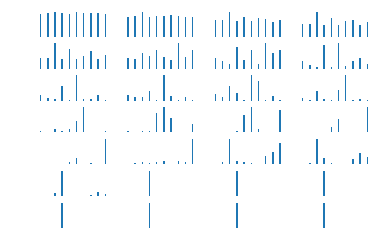

In [15]:
h_W = sess.run(W, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias = sess.run(bias, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias.shape = [-1, 10]

bar_index = range(class_num)
for i in xrange(X3_outputs.shape[0]):
    plt.subplot(7, 4, i+1)
    X3_h_shate = X3_outputs[i, :].reshape([-1, hidden_size])
    pro = sess.run(tf.nn.softmax(tf.matmul(X3_h_shate, h_W) + h_bias))
    plt.bar(bar_index, pro[0], width=0.2 , align='center')
    plt.axis('off')
plt.show()

在上面的图中，为了更清楚地看到线条的变化，我把坐标都去了，每一行显示了 4 个图，共有 7 行，表示了一行一行读取过程中，模型对字符的识别。可以看到，在只看到前面的几行像素时，模型根本认不出来是什么字符，随着看到的像素越来越多，最后就基本确定了它是字符 3.